### 観測データ
解析に必要なデータ
- XFFTS data
- encoder (doppler計算できない)
- weather status
- hosei copy
- obs copy


### 解析フロー

- doppler tracking[x]
- Chopper Wheel [o]
- baseline fitting [o]
- Scaling(from standard object?) [x]
- regrid [o]
    - rms [o]
    - distance [o]
- +header [o]
- 3d-fits[o]

In [94]:
!ls /home/amigos/data/position_switching2019/n20190831094711_12CO_2-1_otf_OriKL/
import time
start_time = time.time()

hosei_230.txt  ps_OriKL.obs  weather.csv  xffts.ndf


In [95]:
#radec 変換データ作成
#! python analy_coordinates.py
import sys
sys.path.append("../script/")
import subprocess
import os
import numpy
import matplotlib.pyplot as plt
from tqdm import tqdm
from joblib import Parallel, delayed
import numba
from astropy.io import fits
###以下独自
import n2df
import read_obsfile
import analy_doppler_nanten

In [96]:
analy_dir = "/home/amigos/data/position_switching2019/n20190831094711_12CO_2-1_otf_OriKL/"
#hosei parameters= 0
subprocess.getoutput(["ls {}".format(analy_dir)]).split("\n")

['hosei_230.txt', 'ps_OriKL.obs', 'weather.csv', 'xffts.ndf']

In [97]:
import log_weather
import numpy
###気象情報の読み込み
weather_data = log_weather.Weather_log(os.path.join(analy_dir, "weather.csv")).read()
print(weather_data)
#気象データの確認
press = numpy.mean(weather_data["press"])
humi = numpy.mean(weather_data["outhumi"])
temp = numpy.mean(weather_data["outtemp"])
lamda = 1300
print(press, humi, temp)

cabin_temp = weather_data["cabin_temp1"]

      timestamp     intemp    outtemp    inhumi   outhumi     winddir  \
0  1.567245e+09  14.857785  15.843675  1.741377  8.028878  268.153028   
1  1.567245e+09  15.050017  16.031286  1.724917  8.666767  268.257228   
2  1.567245e+09  14.335339  16.083172  1.260440  8.466065  268.512126   
3  1.567245e+09  14.554437  16.489913  1.746274  8.558903  268.347264   
4  1.567245e+09  15.064663  16.237868  1.592604  8.503785  268.208857   

     windsp       press      rain  cabin_temp1  cabin_temp2  dome_temp1  \
0  6.021087  570.283874  0.750805    22.132590    32.362389   10.306972   
1  6.084032  570.250022  0.460011    21.946995    32.578530   10.191139   
2  6.541435  570.993875  0.564279    21.702449    32.486717   10.502599   
3  5.986998  570.508561  0.718839    22.178560    32.245174    9.863840   
4  6.538047  570.759913  0.495547    21.647361    31.814305    9.893732   

   dome_temp2  gen_temp1  gen_temp2  scan_num  obs_mode  
0   13.455330  10.158817  13.598950         0       

In [98]:
array_num = 2#1~16IF 

## doppler tracking


In [99]:
#this will be added
from numpy import deg2rad
d = analy_doppler_nanten.doppler_nanten()

### 分光データの読み出し
on/off/hot indexの整理

In [100]:
%%time
n = n2df.Read(os.path.join(analy_dir, "xffts.ndf"))
array_data = n.read_onearray(array_num)#1IFの分光データ
obs_mode = n.read_obs_mode()#観測モード（ON/OFF/HOT）
scan_num = n.read_scan_num()#スキャンライン（0,1,2,3,4,...）
###array_data, scan_num, obs_mode = n.read_for_otf(1)#3分くらいかかた



  0%|          | 0/1163 [00:00<?, ?it/s]

100%|██████████| 1163/1163 [00:00<00:00, 15500.84it/s]

  0%|          | 0/1163 [00:00<?, ?it/s]

100%|██████████| 1163/1163 [00:00<00:00, 182812.11it/s]

  0%|          | 0/1163 [00:00<?, ?it/s]

100%|██████████| 1163/1163 [00:00<00:00, 633092.22it/s]

$$$##
CPU times: user 32 ms, sys: 72 ms, total: 104 ms
Wall time: 114 ms


In [101]:
###index探し
obs_mode = numpy.array(obs_mode)
scan_num = numpy.array(scan_num)

offmask = obs_mode == "OFF"
offindex = numpy.where(offmask == True)

hotmask = obs_mode == "HOT"
hotindex = numpy.where(hotmask == True)

onmask = obs_mode == "ON"
onindex = numpy.where(onmask == True)

max_scannum = numpy.max(scan_num)#Caution! scan num starts from 0, so scan number of 26 indicates 27 times scan

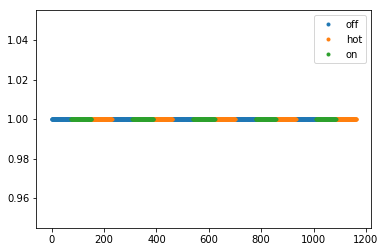

In [102]:
#一応indexの可視化
plt.plot(offindex[0], [1]*len(offindex[0]),"." , label = "off")
plt.plot(hotindex[0], [1]*len(hotindex[0]),"." , label = "hot")
plt.plot(onindex[0], [1]*len(onindex[0]),"." , label = "on")
plt.legend()
plt.show()

[0 0 0 ... 5 5 5]


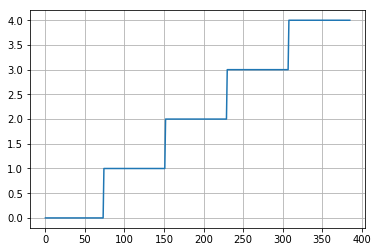

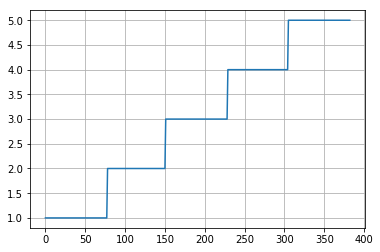

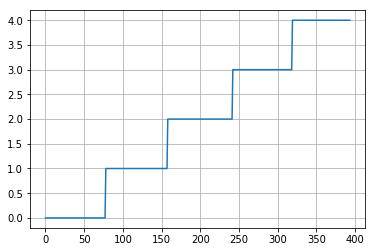

In [103]:
#OFF 点のscan number を取得
scan_num = numpy.array(scan_num)
print(scan_num)
offindex[0]
plt.plot(scan_num[offindex[0]])
plt.grid()
plt.show()

#HOT 点のscan number を取得
scan_num = numpy.array(scan_num)
hotindex[0]
plt.plot(scan_num[hotindex[0]])
plt.grid()
plt.show()

# ON 点のscan number を取得
scan_num = numpy.array(scan_num)
plt.plot(scan_num[onindex[0]])
plt.grid()
plt.show()

### hot/offの積分

In [17]:
#HOT積分
print(numpy.unique(scan_num[hotindex[0]]))#HOT のscan number
hotnum = numpy.unique(scan_num[hotindex[0]])#HOTの数

hotdata = []

for i in tqdm(hotnum):#i = scan number
    mask = scan_num == i#特定のscannumのindexを抜き出す
    index = numpy.where(mask == True)#特定のscannumのindex変数
   ### 
    c = numpy.in1d(index[0], hotindex[0])#特定のscannumのindex&HOT index
    c = numpy.where(c == True)[0]
    ###
    mm = index[0][c]#scan numの値でフィルターしたhot
    #print(mm)
    ###積分
    tmp = [array_data[j] for j in mm]
    hotdata.append(sum(tmp)/len(tmp))
    pass

#下は擬似データの質が低いための処理。将来的に削除
hotdata = numpy.array(hotdata)
hotdata = hotdata + 5000

100%|██████████| 5/5 [00:00<00:00, 434.08it/s]

[1 2 3 4 5]


In [43]:
##OFFの積分
print(numpy.unique(scan_num[offindex[0]]))#HOT のscan number
offnum = numpy.unique(scan_num[offindex[0]])#HOTの数

offdata = []
scan_num = numpy.array(scan_num)

for i in tqdm(offnum):
    mask = scan_num == i#特定のscannumのindexを抜き出す
    index = numpy.where(mask == True)#特定のscannumのindex変数
   ### 
    c = numpy.in1d(index[0], offindex[0])#特定のscannumのindex&HOT index
    c = numpy.where(c == True)[0]#scannumとhotで絞ったindex
    mm = index[0][c]#scan numの値でフィルターしたhot
    tmp = [array_data[j] for j in mm]
    offdata.append(sum(tmp)/len(tmp))


100%|██████████| 5/5 [00:00<00:00, 497.00it/s]

[0 1 2 3 4]


In [69]:
##ONの積分
print(numpy.unique(scan_num[onindex[0]]))#HOT のscan number
on_num = numpy.unique(scan_num[onindex[0]])#HOTの数

ondata = []
scan_num = numpy.array(scan_num)

for i in tqdm(on_num):
    mask = scan_num == i#特定のscannumのindexを抜き出す
    index = numpy.where(mask == True)#特定のscannumのindex変数
   ### 
    c = numpy.in1d(index[0], onindex[0])#特定のscannumのindex&HOT index
    c = numpy.where(c == True)[0]#scannumとhotで絞ったindex
    mm = index[0][c]#scan numの値でフィルターしたhot
    tmp = [array_data[j] for j in mm]
    ondata.append(sum(tmp)/len(tmp))


100%|██████████| 5/5 [00:00<00:00, 492.81it/s]

[0 1 2 3 4]


Hot のデータはscan line分あるわけでないので補完
Off もscan line 分ある観測プログラムしかないはずだが、一応補完

補完の方法は次のOFF/HOTの点の観測を行うまでは直近のデータを採用する形

In [70]:
# ###Choper wheel
@numba.jit
def chopper_wheel(on, off, hot, temprature = 300):
    Tastar = (on - off)/(hot - off) * temprature
    return Tastar

In [89]:
chdata = [chopper_wheel(ondata[i], offdata[i], hotdata[i]) for i in range(len(ondata))]

## Baseline fitting



  0%|          | 0/5 [00:00<?, ?it/s]

100%|██████████| 5/5 [00:00<00:00, 274.46it/s]

3000 7500 8500 30000


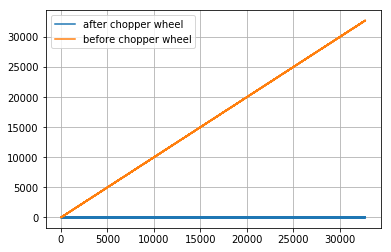

In [93]:
#baseline fitting parameter
center = 8000
width = 1000
start = 3000
end = 30000

#baseline fitting function
def f(x, a, b, c):
    return a*x**2 + b*x + c

def  baseline_fitting(arr_x, arr_y, index1, index2, index3, index4):
    tmpdata_y1 = arr_y[index1:index2]
    tmpdata_y2 = arr_y[index3:index4]
    tmpdata_x1 = arr_x[index1:index2]
    tmpdata_x2 = arr_x[index3:index4]
    x = numpy.concatenate([tmpdata_x1, tmpdata_x2])
    y = numpy.concatenate([tmpdata_y1, tmpdata_y2])
    param = numpy.polyfit(x, y, 2)
    arr_y = arr_y - f(arr_x, *param)
    return arr_y
    
#ch
xindex = numpy.linspace(0, 32768, 32768)

#baseline fitting index
index1 = int(start)
index2 = int(center - width/2)
index3 = int(center + width/2)
index4 = int(end)
print(index1, index2, index3, index4)

testoffset = numpy.linspace(1, 32768, 32768)

for i in tqdm(range(len(chdata))):
    chdata[i] = chdata[i] + testoffset#ベースラインフィッティングできているかの確認のため
    origin = chdata[i]#for debug, this will be deleted
    chdata[i] = baseline_fitting(chdata[i], xindex, index1, index2, index3, index4)
    
    
plt.plot(chdata[i], label="after chopper wheel")#after chopper wheel
plt.plot(origin, label="before chopper wheel")#before chopper wheel
plt.legend()
plt.grid()

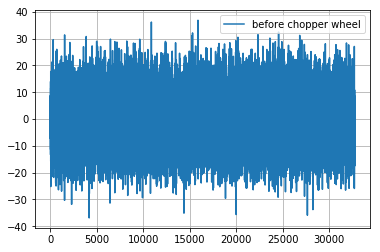

In [50]:
#plt.plot(data_on[i], label="after chopper wheel")#after chopper wheel
%matplotlib inline
plt.plot(origin-testoffset, label="before chopper wheel")#before chopper wheel
plt.legend()
plt.grid()

### astropyでfitsに書き出す

In [52]:
#3軸の入れ替え。
data_c = numpy.swapaxes(data_c, 0,2)
print(numpy.shape(data_c))#軸の入れ替えの確認

NameError: name 'data_c' is not defined

ヘッダーの作成

In [ ]:
header_dict = {
"object" : obsfile_dict["object"],
"crval1" : obsfile_dict["lambda_on"],
"cdelt1" : obsfile_dict["grid"]/3600,
"crpix1" : obsfile_dict["N"]-1/2,#中心ピクセル
"crval2" : obsfile_dict["beta_on"],
"cdelt2" : obsfile_dict["grid"]/3600,
"crpix2" : obsfile_dict["N"]-1/2 #中心ピクセル
}

In [53]:
temp = """
SIMPLE  =                    T                                                  
BITPIX  =                  -32                                                  
NAXIS   =                    3                                                  
NAXIS1  =                  31                                                 
NAXIS2  =                  31                                                 
NAXIS3  =                   32768                                                  
OBJECT  = '{object}              '                                                  
TELESCOP= 'NANTEN2            '                                                  
INSTRUME= 'MULT2-11          '                                                  
OBSERVER= 'z7510rk           '                                                  
DATE-OBS= '2007-12-30        '                                                  
DATE-MAP= '2012-01-19        '                                                  
BSCALE  =    0.10000000000E+01                                                  
BZERO   =    0.00000000000E+01                                                  
BUNIT   = 'K                 '                                                  
EPOCH   =    0.20000000000E+04                                                  
OBSRA   =    8.38104170000E+01                                                  
OBSDEC  =   -5.37511100000E+00                                                  
DATAMAX =    1.16774444580E+02                                                  
DATAMIN =   -8.33924560547E+01                                                  
CTYPE1  = 'RA---GLS          '                                                  
CRVAL1  =    {crval1}                                                  
CDELT1  =    {cdelt1}                                                  
CRPIX1  =      {crpix1}
CROTA1  =     0.0000000000E+00                                                  
CTYPE2  = 'DEC--GLS          '                                                  
CRVAL2  =   {crval2}                                                  
CDELT2  =   {cdelt2}                                               
CRPIX2  =     {crpix2}                                               
CROTA2  =     0.0000000000E+00                                                  
CTYPE3  = 'VELO-LSR          '                                                  
CRVAL3  =    2.50000000000E+02                                                  
CDELT3  =    5.00000000000E+02                                                  
CRPIX3  =    1.00000000000E+00                                                  
CROTA3  =    0.00000000000E+00                                                  
BLANK   =   -1.00000000000E+00 """.format(**header_dict)

ERROR:root:An unexpected error occurred while tokenizing input
The following traceback may be corrupted or invalid
The error message is: ('EOF in multi-line string', (1, 31))



NameError: name 'header_dict' is not defined

In [54]:
target_header = fits.Header.fromstring(temp, sep = "\n")

TypeError: object of type 'float' has no len()

In [ ]:
#書き出し
hdu = fits.PrimaryHDU(data_c, target_header)
hdulist = fits.HDUList([hdu])
hdulist.writeto("test4.fits", overwrite = True)

In [ ]:
##読み込み
hdu_list = fits.open("test4.fits")
hdu_r = hdu_list[0]
data = hdu_r.data
header = hdu_r.header

In [ ]:
#解析にかかった時間を出すため
print("required time : {}".format(time.time() - start_time))

In [ ]:
#%matplotlib notebook
%matplotlib inline
from ipywidgets import interact

def plot(i):
    plt.figure(figsize=(8, 8))
    plt.imshow(data[i].T, cmap = "gist_rainbow")
    #plt.xlabel("ra")
    #plt.ylabel("dec")
    plt.show()


interact(plot, i = (0,16000,1))